In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import Aer, QuantumCircuit, execute, ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator


from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
aer_sim = Aer.get_backend('aer_simulator')

# This method applies noise to measurement and gates with prob. p_meas and p_gate, resectively 
def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


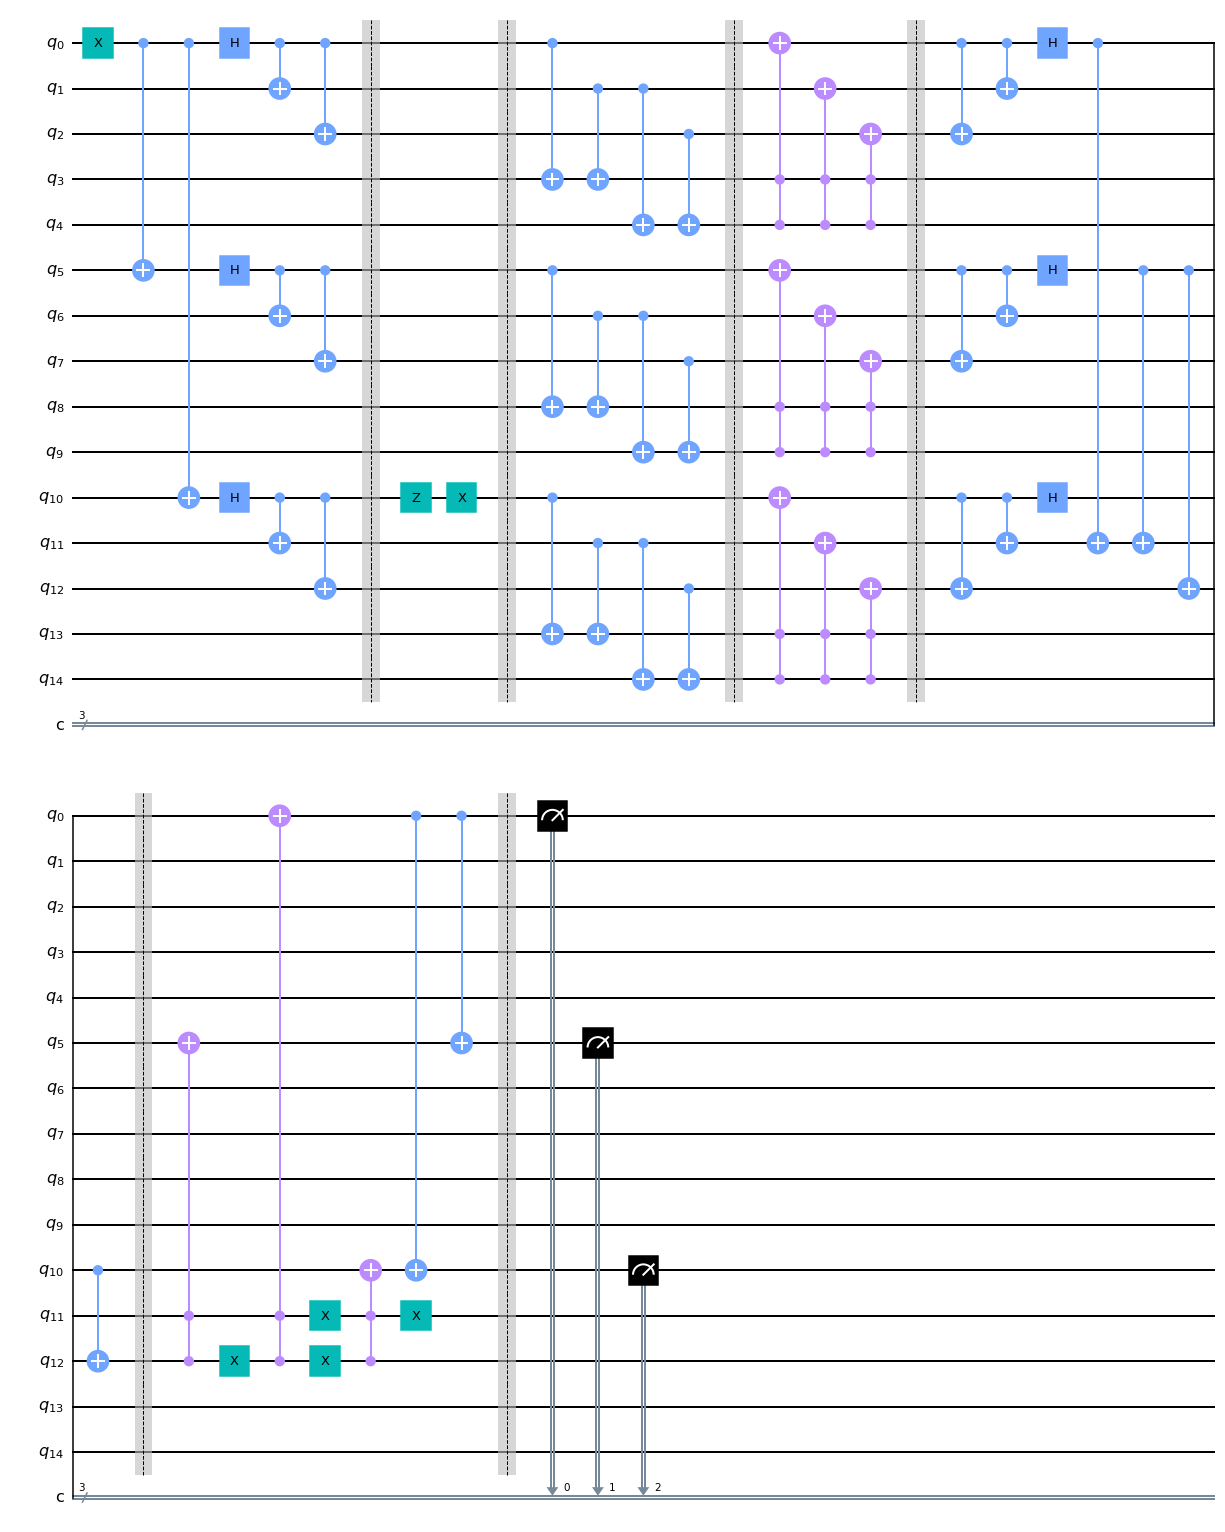

In [11]:
#initiating quantum and classical registers 
qreg_q = QuantumRegister(15, 'q')
creg_c = ClassicalRegister(3, 'c')

#initiating circuit
circuit = QuantumCircuit(qreg_q, creg_c)

#encoding the circuit
circuit.x(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[5])
circuit.cx(qreg_q[0], qreg_q[10])

#adding hadamard gates for superposition to generate |+> and |-> states (for phase flip error detection)
circuit.h(qreg_q[0])
circuit.h(qreg_q[5])
circuit.h(qreg_q[10])

circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[5], qreg_q[6])
circuit.cx(qreg_q[10], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[7])
circuit.cx(qreg_q[10], qreg_q[12])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.barrier()

#simulating flip error
#circuit.z(qreg_q[10])
#circuit.x(qreg_q[10])
#circuit.barrier()

#phase-flip error detection circuit 
circuit.cx(qreg_q[0], qreg_q[3])
circuit.cx(qreg_q[5], qreg_q[8])
circuit.cx(qreg_q[10], qreg_q[13])

circuit.cx(qreg_q[11], qreg_q[13])
circuit.cx(qreg_q[6], qreg_q[8])
circuit.cx(qreg_q[1], qreg_q[3])

circuit.cx(qreg_q[11], qreg_q[14])
circuit.cx(qreg_q[6], qreg_q[9])
circuit.cx(qreg_q[1], qreg_q[4])
circuit.cx(qreg_q[12], qreg_q[14])
circuit.cx(qreg_q[7], qreg_q[9])
circuit.cx(qreg_q[2], qreg_q[4])

#recovery circuit for phase-flip
circuit.barrier()
circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[10])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[5])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[0])

circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[11])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[6])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[1])

circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[12])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[7])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[2])

#bit-flip error detection circuit 
circuit.barrier()
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[5], qreg_q[7])
circuit.cx(qreg_q[10], qreg_q[12])

circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[5], qreg_q[6])
circuit.cx(qreg_q[10], qreg_q[11])

circuit.h(qreg_q[0])
circuit.h(qreg_q[5])
circuit.h(qreg_q[10])


circuit.cx(qreg_q[0], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[12])
circuit.cx(qreg_q[10], qreg_q[12])


#recovery circuit for bit-flip
circuit.barrier()
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[5])
circuit.x(qreg_q[12])
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[0])
circuit.x(qreg_q[12])
circuit.x(qreg_q[11])
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[10])
circuit.x(qreg_q[11])
circuit.cx(qreg_q[0], qreg_q[10])
circuit.cx(qreg_q[0], qreg_q[5])


#measurement 
circuit.barrier()
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[5], creg_c[1])
circuit.measure(qreg_q[10], creg_c[2])


editor = CircuitComposer(circuit=circuit)
editor

circuit.draw()

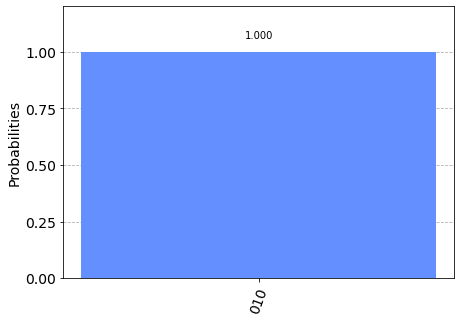

In [12]:
# use local simulator
noise_model = get_noise(0.0,0.0)

qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(circuit)
results = qasm_sim.run(qobj,noise_model=noise_model).result()
answer = results.get_counts()

plot_histogram(answer)